In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data():
    df = pd.read_csv('/content/drive/MyDrive/Infosys Internship/sales_final.csv')
    return df

In [ ]:
def prepare_data(df, month):
    # Feature columns for the current month
    feature_cols = [f'm_{i}' for i in range(1, 70)] + \
                    [f'm_{i}_lag1' for i in range(1, 70)] + \
                    [f'm_{i}_lag2' for i in range(1, 70)] + \
                    [f'm_{i}_lag3' for i in range(1, 70)] + \
                    ['month'] + ['Foods', 'Hobbies', 'Household', 'California', 'Texas', 'Wisconsin']

    # Dynamically check which columns exist and drop them
    columns_to_drop = [f'm_{month}', f'm_{month+1}', f'm_{month+2}'] + \
                      [f'm_{month+1}_lag1', f'm_{month+1}_lag2', f'm_{month+1}_lag3'] + \
                      [f'm_{month+2}_lag1', f'm_{month+2}_lag2', f'm_{month+2}_lag3'] + \
                      ['total_sales'] + \
                      [f'm_{i}_rolling_mean' for i in range(1, 70)] + \
                      [f'm_{i}_rolling_sum' for i in range(1, 70)]

    # Check if columns exist in df before dropping them
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]

    X = df.drop(columns=columns_to_drop)
    y = df[f'm_{month}']

    return X, y, feature_cols

In [ ]:
def train_lgbm_model(X_train, X_test, y_train, y_test, features_lgbm):
    train_data = lgb.Dataset(X_train[features_lgbm], label=y_train)
    test_data = lgb.Dataset(X_test[features_lgbm], label=y_test, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'l2',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }
    rounds = 100
    model_lgbm = lgb.train(params, train_data, rounds, valid_sets=[test_data])
    return model_lgbm

In [ ]:
def train_xgboost_model(X_train, X_test, y_train, y_test, features_xgboost):
    model_xgboost = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    model_xgboost.fit(X_train[features_xgboost], y_train)
    return model_xgboost

In [ ]:
def stack_and_predict(model_xgboost, model_lgbm, meta_model, X, features_xgboost, features_lgbm):
    predictions_xgboost = model_xgboost.predict(X[features_xgboost])
    predictions_lgbm = model_lgbm.predict(X[features_lgbm], num_iteration=model_lgbm.best_iteration)

    stacked_predictions = np.column_stack((predictions_xgboost, predictions_lgbm))
    final_predictions = meta_model.predict(stacked_predictions)
    return final_predictions

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, features_xgboost, features_lgbm):
    model_lgbm = train_lgbm_model(X_train, X_test, y_train, y_test, features_lgbm)
    model_xgboost = train_xgboost_model(X_train, X_test, y_train, y_test, features_xgboost)

    predictions_xgboost = model_xgboost.predict(X_test[features_xgboost])
    predictions_lgbm = model_lgbm.predict(X_test[features_lgbm], num_iteration=model_lgbm.best_iteration)

    mae_xgboost = mean_absolute_error(y_test, predictions_xgboost)
    mse_xgboost = mean_squared_error(y_test, predictions_xgboost)
    print(f'MAE (XGBoost): {mae_xgboost}, MSE (XGBoost): {mse_xgboost}')

    mae_lgbm = mean_absolute_error(y_test, predictions_lgbm)
    mse_lgbm = mean_squared_error(y_test, predictions_lgbm)
    print(f'MAE (LGBM): {mae_lgbm}, MSE (LGBM): {mse_lgbm}')

    stacked_predictions = np.column_stack((predictions_xgboost, predictions_lgbm))
    meta_model = RandomForestRegressor(n_estimators=100, random_state=42)
    meta_model.fit(stacked_predictions, y_test)

    final_predictions = meta_model.predict(stacked_predictions)
    print(f"MAE (stacked model): {mean_absolute_error(y_test, final_predictions)}")
    print(f"MSE (stacked model): {mean_squared_error(y_test, final_predictions)}")

    return model_xgboost, model_lgbm, meta_model, predictions_lgbm, predictions_xgboost

In [ ]:
df = load_data()
results = pd.DataFrame()
months = [67, 68, 69]

for month in months:
    print(f"Training model for m_{month}...")
    X, y, feature_cols = prepare_data(df, month)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Load optimal features for XGBoost and LGBM
    with open(f'/content/drive/MyDrive/Infosys Internship/optimal_features_{month}.pkl', 'rb') as f:
        features_xgboost = pickle.load(f)
    with open(f'/content/drive/MyDrive/Infosys Internship/LGBM/optimal_features_{month}_lgbm.pkl', 'rb') as f:
        features_lgbm = pickle.load(f)

    # Train and evaluate the model
    model_xgboost, model_lgbm, meta_model, predictions_lgbm, predictions_xgboost = train_and_evaluate(
        X_train, X_test, y_train, y_test, features_xgboost, features_lgbm)

    # Predict the next month's values
    final_predictions = stack_and_predict(model_xgboost, model_lgbm, meta_model, X_test, features_xgboost, features_lgbm)
    results[f'm_{month}_Actual']= y_test.values
    results[f'm_{month}_Predicted']= final_predictions

    # Prepare data for the next month (e.g., m_68 will predict m_69)
    X_next = pd.concat([X, pd.DataFrame({f'm_{month}': final_predictions})], axis=1)
    X_next[f'm_{month+1}_lag1'] = X_next[f'm_{month}']
    X_next[f'm_{month+1}_lag2'] = df[f'm_{month-1}']
    X_next[f'm_{month+1}_lag3'] = df[f'm_{month-2}']

    # Rolling features
    X_next[f'm_{month+1}_rolling_mean'] = X_next[[f'm_{month}']].rolling(window=3, min_periods=1).mean()
    X_next[f'm_{month+1}_rolling_sum'] = X_next[[f'm_{month}']].rolling(window=3, min_periods=1).sum()

    # Drop the rolling features and prepare for the next round
    X_next = X_next.drop(columns=[f'm_{month+1}_rolling_mean', f'm_{month+1}_rolling_sum'], errors='ignore')
results_df = pd.DataFrame(results)

Training model for m_67...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44641
[LightGBM] [Info] Number of data points in the train set: 7317, number of used features: 178
[LightGBM] [Info] Start training from score 146.489135
MAE (XGBoost): 11.176186027780908, MSE (XGBoost): 551.9560368900999
MAE (LGBM): 11.712941678743299, MSE (LGBM): 594.9046356173657
MAE (stacked model): 4.791816302367941
MSE (stacked model): 120.236988386445
Training model for m_68...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45141
[LightGBM] [Info] Number of data points in the train set: 7317, number of used features: 180
[LightGBM] [Info] Start training from score 147.351374
MAE (XGBoost): 11.237315394448453, MSE (XGBoost):

In [ ]:
results_df.head()

,m_67_Actual,m_67_Predicted,m_68_Actual,m_68_Predicted,m_69_Actual,m_69_Predicted
0,819,801.34,963,884.28,632,699.44
1,1161,1043.92,850,850.32,642,717.28
2,709,866.31,615,684.74,638,580.49
3,707,666.53,920,874.88,665,688.31
4,793,736.74,692,702.33,617,647.02


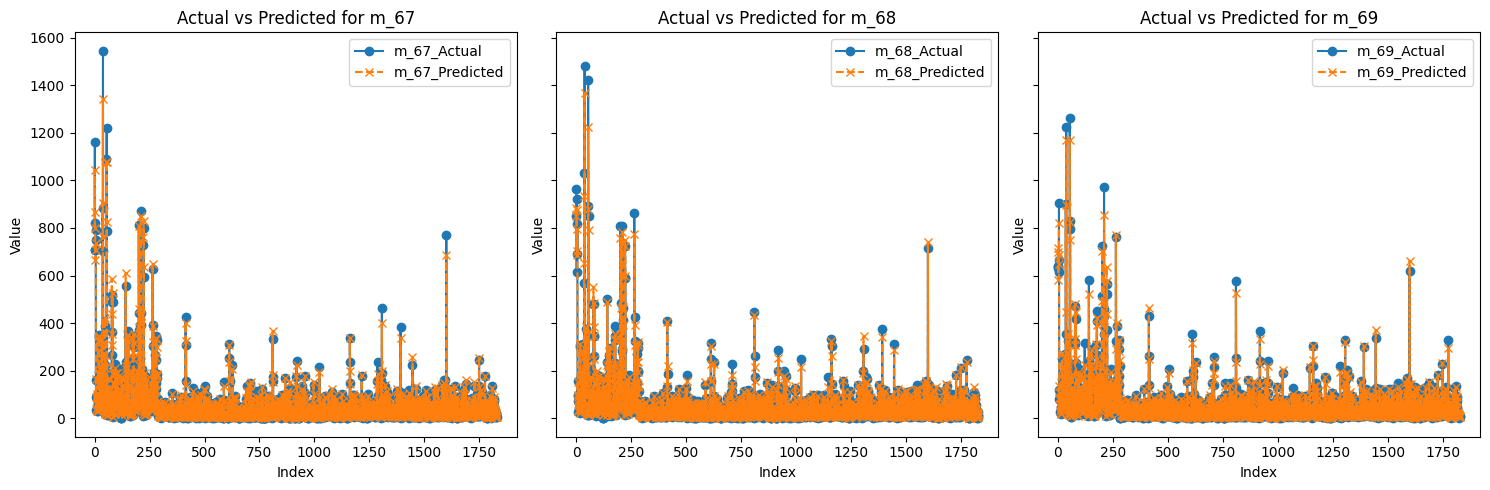

In [ ]:
fig, axes = plt.subplots(1, len(months), figsize=(15, 5), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]
    ax.plot(results_df[f'm_{month}_Actual'], label=f'm_{month}_Actual', linestyle='-', marker='o')
    ax.plot(results_df[f'm_{month}_Predicted'], label=f'm_{month}_Predicted', linestyle='--', marker='x')
    ax.set_title(f'Actual vs Predicted for m_{month}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

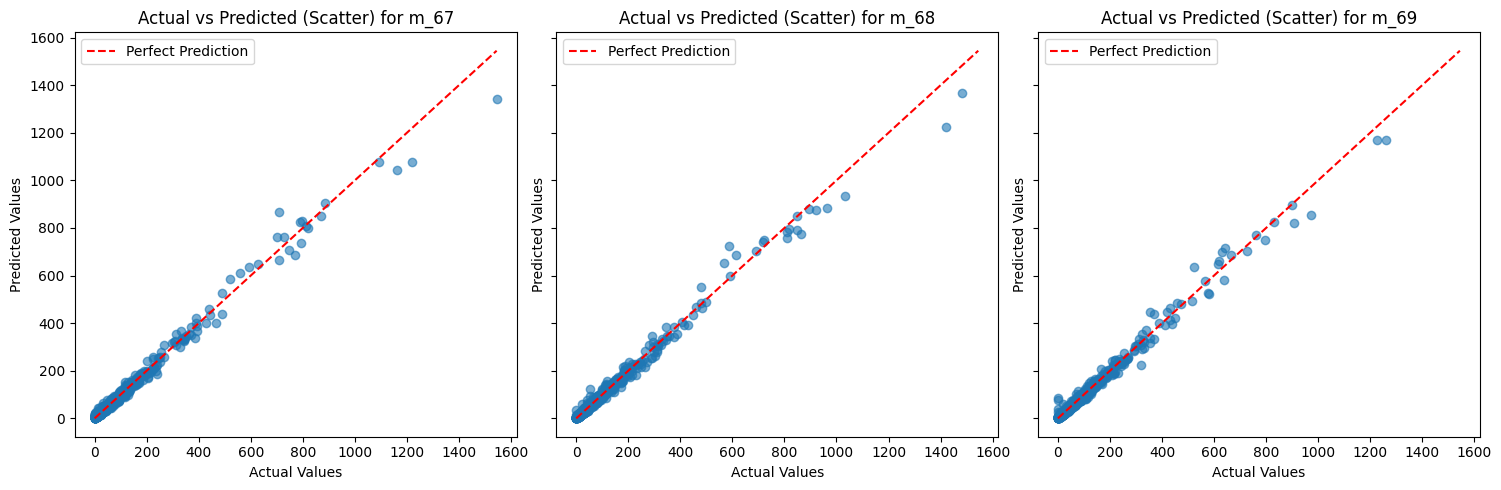

In [ ]:
fig, axes = plt.subplots(1, len(months), figsize=(15, 5), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]
    ax.scatter(results_df[f'm_{month}_Actual'], results_df[f'm_{month}_Predicted'], alpha=0.6)
    ax.plot([results_df.min().min(), results_df.max().max()], [results_df.min().min(), results_df.max().max()], 'r--', label="Perfect Prediction")
    ax.set_title(f'Actual vs Predicted (Scatter) for m_{month}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.legend()

plt.tight_layout()
plt.show()

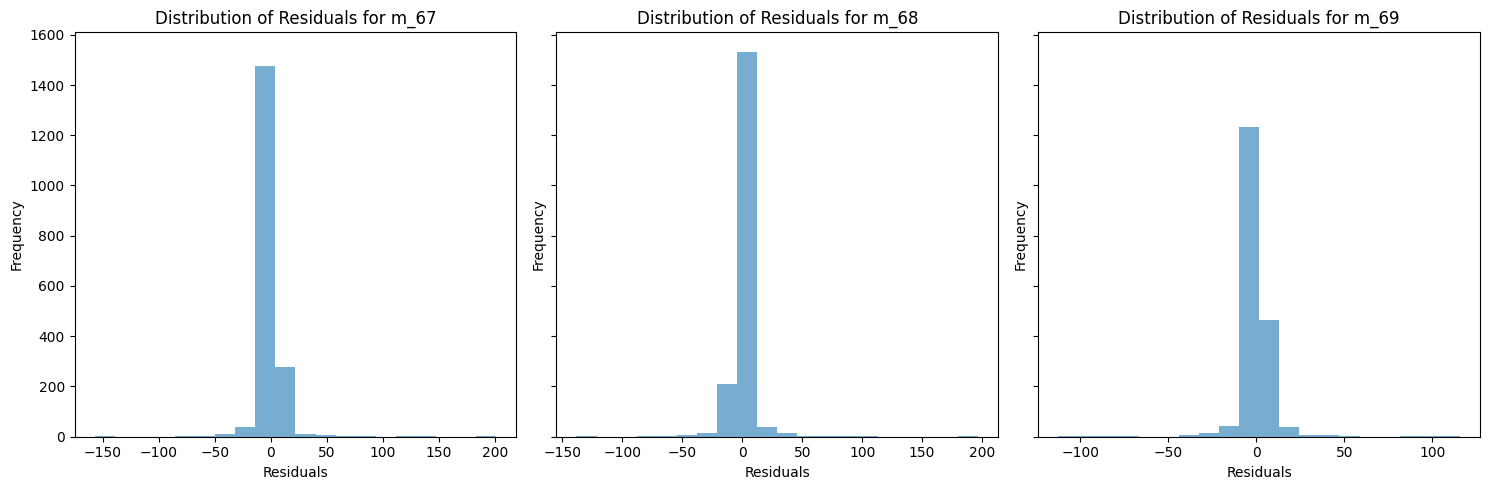

In [ ]:
fig, axes = plt.subplots(1, len(months), figsize=(15, 5), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]
    residuals = results_df[f'm_{month}_Actual'] - results_df[f'm_{month}_Predicted']
    ax.hist(residuals, bins=20, alpha=0.6)
    ax.set_title(f'Distribution of Residuals for m_{month}')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
metrics = {'Month': [], 'MAE': [], 'RMSE': [], 'R2': []}

for month in months:
    y_true = results_df[f'm_{month}_Actual']
    y_pred = results_df[f'm_{month}_Predicted']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    metrics['Month'].append(month)
    metrics['MAE'].append(mae)
    metrics['RMSE'].append(rmse)
    metrics['R2'].append(r2)

metrics_df = pd.DataFrame(metrics)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
metrics_df

,Month,MAE,RMSE,R2
0,67,4.791816,10.965263,0.989261
1,68,4.581833,10.765754,0.989328
2,69,4.474527,9.877759,0.989507
